<small><i>This notebook was put together by [Wesley Beckner](http://wesleybeckner.github.io/).</i></small>

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from __future__ import print_function
from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem import Descriptors
from rdkit.ML.Descriptors.MoleculeDescriptors import MolecularDescriptorCalculator as Calculator

%matplotlib inline

plt.rc("figure", facecolor="white")

params = {
    'lines.markersize' : 10,
    'axes.labelsize': 20,
    'font.size': 20,
    'legend.fontsize': 20,
    'xtick.labelsize': 20,
    'ytick.labelsize': 20,
    'text.usetex': False,
   }

tableau20 = [(31, 119, 180), (174, 199, 232), (255, 127, 14), (255, 187, 120),    
             (44, 160, 44), (152, 223, 138), (214, 39, 40), (255, 152, 150),    
             (148, 103, 189), (197, 176, 213), (140, 86, 75), (196, 156, 148),    
             (227, 119, 194), (247, 182, 210), (127, 127, 127), (199, 199, 199),    
             (188, 189, 34), (219, 219, 141), (23, 190, 207), (158, 218, 229)]   

# Scale the RGB values to the [0, 1] range, which is the format matplotlib accepts.    
for i in range(len(tableau20)):    
    r, g, b = tableau20[i]    
    tableau20[i] = (r / 255., g / 255., b / 255.) 

In [3]:
import rdkit
# import pychem 
# from pychem.pychem import PyChem2d, PyChem3d
# from rdkit import Chem
# from rdkit.Chem import AllChem

import pandas as pd
import matplotlib.pylab as plt
import numpy as np
import itertools as it
from sklearn.linear_model import LassoLarsIC
from sklearn.linear_model import Lasso
from sklearn.svm import SVR
from __future__ import print_function
import numpy.linalg as LINA
from sklearn.preprocessing import StandardScaler
%matplotlib inline

plt.rc("figure", facecolor="white")

params = {
    'lines.markersize' : 10,
    'axes.labelsize': 20,
    'font.size': 20,
    'legend.fontsize': 20,
    'xtick.labelsize': 20,
    'ytick.labelsize': 20,
    'text.usetex': False,
   }

tableau20 = [(31, 119, 180), (174, 199, 232), (255, 127, 14), (255, 187, 120),    
             (44, 160, 44), (152, 223, 138), (214, 39, 40), (255, 152, 150),    
             (148, 103, 189), (197, 176, 213), (140, 86, 75), (196, 156, 148),    
             (227, 119, 194), (247, 182, 210), (127, 127, 127), (199, 199, 199),    
             (188, 189, 34), (219, 219, 141), (23, 190, 207), (158, 218, 229)]   

# Scale the RGB values to the [0, 1] range, which is the format matplotlib accepts.    
for i in range(len(tableau20)):    
    r, g, b = tableau20[i]    
    tableau20[i] = (r / 255., g / 255., b / 255.)   

    
# salts=pd.read_csv('Viscosity.csv',delimiter=',')
# #salts=pd.read_csv('cocosalts.csv',delimiter='\t')
# #salts=pd.read_csv('nonchlsalts.csv')
# salts = salts[salts.NAME_ANI != 'chloride']  #chloride returns an error in pychem
# salts = salts[salts.NAME_ANI != 'bromide']  #bromide returns an error in pychem
# salts = salts[salts.NAME_ANI != 'trifluorotris(perfluoroethyl)phosphate(V)']
# salts = salts[salts.NAME_ANI != 'iodide']
# salts = salts.reset_index() #reset the index so our for loops work

# MDsalts=pd.read_csv('combinedviscosity.csv',delimiter=',')

ImportError: No module named rdkit

<a id='top'></a>
# 2D descriptor selection with LASSO and SVR

PyChem calculates 1266 descriptors for each of the IL pairs. Single atom ions cause PyChem to return an error, so those are removed from the dataset. Viscosity, cation, and anion data are appended to the pandas data frame

If not making changes to the starting dataset, load the .npy file directly [here](#direct load)

load the train/test split according to MD calcs data [here](#splitByMD)

load the scikit svr code [here](#svr load)

load generic lasso train/test sets [here](#lasso load)

load coco's lasso code [here](#coco lasso load)

load the scikit lasso code [here](#lasso scikit load)

## Algorithmic solvent search

load cation, anion pairing code [here](#mix)

If not making changes to the mixed salts, load the .npy file directly [here](#direct)

load SVR prediction [here](#svr)

load coco's prediction [here](#coco)

load scikit lasso prediction [here](#lasso)

## Other regression methods

load the choose code [here](#choose code)

load the choose 10 lasso code [here](#lasso code)

load the PCA code [here](#pca code)

load the choose results [here](#descriptor load)

[read about the descriptors](#background)

In [108]:
###READ SMILES INTO PYCHEM AND CREATE DATAFRAME
cats = pd.DataFrame(columns=salts['NAME_CAT']) #loop through all the salts
old = pd.DataFrame()
new = pd.DataFrame()
for a, b in enumerate(salts['NAME_CAT']):    
    catdes=[] #descriptors for cations
    andes=[] #descriptors for anions
    cat=PyChem2d() #create PyChem molecular instances
    an=PyChem2d()
    try:
        print(b,salts['SMILE_anion'][a]) #check that we're computing
        cat.ReadMolFromSmile(np.str(salts['SMILE_cation'][a])) #cation
        an.ReadMolFromSmile(np.str(salts['SMILE_anion'][a])) #anion
        andes.append(an.GetAllDescriptor()) 
        catdes.append(cat.GetAllDescriptor()) #add all the descriptors    
        dfan = pd.DataFrame(andes) #turn the array into a dataframe
        dfcat = pd.DataFrame(catdes)
        dfan.rename(columns=lambda x: x + 'anion', inplace=True) #rename headers (cation or anion)
        dfcat.rename(columns=lambda x: x + 'cation', inplace=True)
        df = pd.concat([dfcat, dfan], axis=1) #concatonate cationic and anionic descriptor df's
        if a != 0: #grow the dataframe
            new = pd.concat([df, old], axis=0)
        old = new
    except: #note that single-atom ions return an error in pychem, if failed computations are indicated remove problem
        pass #entries in the cell above
        print('failed ',b,salts['NAME_ANI'][a])

1-ethyl-3-methylimidazolium C(#N)[N-]C#N
1-ethyl-3-methylimidazolium C(#N)[N-]C#N
1-ethyl-3-methylimidazolium C(#N)[N-]C#N
1-ethyl-3-methylimidazolium C(#N)[N-]C#N
1-ethyl-3-methylimidazolium C(#N)[N-]C#N
1-ethyl-3-methylimidazolium C(#N)[N-]C#N
1-ethyl-3-methylimidazolium C(#N)[N-]C#N
1-ethyl-3-methylimidazolium C(#N)[N-]C#N
1-ethyl-3-methylimidazolium C(#N)[N-]C#N
1-ethyl-3-methylimidazolium C(#N)[N-]C#N
1-ethyl-3-methylimidazolium C(#N)[N-]C#N
1-ethyl-3-methylimidazolium C(#N)[N-]C#N
1-ethyl-3-methylimidazolium C(#N)[N-]C#N
1-ethyl-3-methylimidazolium C(#N)[N-]C#N
1-ethyl-3-methylimidazolium C(#N)[N-]C#N
1-ethyl-3-methylimidazolium C(#N)[N-]C#N
1-ethyl-3-methylimidazolium C(#N)[N-]C#N
1-ethyl-3-methylimidazolium C(#N)[N-]C#N
1-ethyl-3-methylimidazolium C(C(F)(F)S(=O)(=O)NS(=O)(=O)C(C(F)(F)F)(F)F)(F)(F)F
1-butyl-3-methylimidazolium  CC(=O)[O-]
1-butyl-3-methylimidazolium  CC(=O)[O-]
1-butyl-3-methylimidazolium  CC(=O)[O-]
1-butyl-3-methylimidazolium  CC(=O)[O-]
1-butyl-3-methylimidaz

In [33]:
###Append these values in a separate step since 
###calculating the descriptors is computationally expensive

desc = new
desc=desc.reset_index()
desc.loc[:,'T'] = pd.Series(salts['T'], index=desc.index)
for a in range(len(salts['T'])):
    desc.iloc[a-1,-1] = salts['T'][a]
desc.loc[:,'P'] = pd.Series(salts['P'], index=desc.index)
for a in range(len(salts['P'])):
    desc.iloc[a-1,-1] = salts['P'][a]
desc.loc[:,'NAME_CAT'] = pd.Series(salts['NAME_CAT'], index=desc.index)
for a in range(len(salts['NAME_CAT'])):
    desc.iloc[a-1,-1] = salts['NAME_CAT'][a]
desc.loc[:,'NAME_ANI'] = pd.Series(salts['NAME_ANI'], index=desc.index)
for a in range(len(salts['NAME_ANI'])):
    desc.iloc[a-1,-1] = salts['NAME_ANI'][a]
desc.loc[:,'Viscosity'] = pd.Series(salts['Viscosity'], index=desc.index)
for a in range(len(salts['Viscosity'])):
    desc.iloc[a-1,-1] = salts['Viscosity'][a]

In [35]:
pd.DataFrame.to_csv(desc, path_or_buf='viscositydescriptors')

# Load data cross-referenced with IE calculations 

In [30]:
getIE = MDName[MDName == ILThermoName[a]].index[0]
getIE

8

In [80]:
###READ SMILES INTO PYCHEM AND CREATE DATAFRAME
MDName=pd.Series(MDsalts['SMILE_cation'].str.cat(MDsalts['SMILE_anion'], sep=','))
ILThermoName=pd.Series(salts['SMILE_cation'].str.cat(salts['SMILE_anion'], sep=','))
old = pd.DataFrame()
new = pd.DataFrame()
for a, b in enumerate(salts['NAME_CAT']):    
    catdes=[] #descriptors for cations
    andes=[] #descriptors for anions
    T=[] #temperature for salts
    P=[] #pressure for salts
    nameCat=[]
    nameAn=[]
    viscosity=[]
    IE=[]
    
    cat=PyChem2d() #create PyChem molecular instances
    an=PyChem2d()
    if any(MDName == ILThermoName[a]):
        try:
            getIE = MDName[MDName == ILThermoName[a]].index[0]
            print(b,salts['SMILE_anion'][a]) #check that we're computing
            cat.ReadMolFromSmile(np.str(salts['SMILE_cation'][a])) #cation
            an.ReadMolFromSmile(np.str(salts['SMILE_anion'][a])) #anion
            
            andes.append(an.GetAllDescriptor()) 
            catdes.append(cat.GetAllDescriptor()) #add all the descriptors  
            T.append(salts['T'][a])
            P.append(salts['P'][a])
            nameCat.append(salts['NAME_CAT'][a])
            nameAn.append(salts['NAME_ANI'][a])
            viscosity.append(salts['Viscosity'][a])
            IE.append(MDsalts['IE (MD no charge scaling)'][getIE])
            
            dfan = pd.DataFrame(andes) #turn the array into a dataframe
            dfcat = pd.DataFrame(catdes)
            dfT = pd.DataFrame(T)
            dfP = pd.DataFrame(P)
            dfnameCat = pd.DataFrame(nameCat)
            dfnameAn = pd.DataFrame(nameAn)
            dfviscosity = pd.DataFrame(viscosity)
            dfIE = pd.DataFrame(IE)
            
            dfan.rename(columns=lambda x: x + 'anion', inplace=True) #rename headers (cation or anion)
            dfcat.rename(columns=lambda x: x + 'cation', inplace=True)
            dfT.rename(columns=lambda x: 'Temperature', inplace=True)
            dfP.rename(columns=lambda x: 'Pressure', inplace=True)
            dfnameCat.rename(columns=lambda x: 'Cation Name', inplace=True)
            dfnameAn.rename(columns=lambda x: 'Anion Name', inplace=True)
            dfviscosity.rename(columns=lambda x: 'Viscosity', inplace=True)
            dfIE.rename(columns=lambda x: 'Interaction Energy', inplace=True)
                       
            df = pd.concat([dfcat, dfan, dfT, dfP, dfIE, dfnameCat, dfnameAn, dfviscosity], axis=1) #concatonate cationic and anionic descriptor df's
            
            if a != 0: #grow the dataframe
                new = pd.concat([df, old], axis=0)
            old = new
        except: #note that single-atom ions return an error in pychem, if failed computations are indicated remove problem
            pass #entries in the cell above
            print('failed ',b,salts['NAME_ANI'][a])
    else:
        print('no MD data ',b,salts['NAME_ANI'][a])

no MD data  1-ethyl-3-methylimidazolium  dicyanamide
no MD data  1-ethyl-3-methylimidazolium  dicyanamide
no MD data  1-ethyl-3-methylimidazolium  dicyanamide
no MD data  1-ethyl-3-methylimidazolium  dicyanamide
no MD data  1-ethyl-3-methylimidazolium  dicyanamide
no MD data  1-ethyl-3-methylimidazolium  dicyanamide
no MD data  1-ethyl-3-methylimidazolium  dicyanamide
no MD data  1-ethyl-3-methylimidazolium  dicyanamide
no MD data  1-ethyl-3-methylimidazolium  dicyanamide
no MD data  1-ethyl-3-methylimidazolium  dicyanamide
no MD data  1-ethyl-3-methylimidazolium  dicyanamide
no MD data  1-ethyl-3-methylimidazolium  dicyanamide
no MD data  1-ethyl-3-methylimidazolium  dicyanamide
no MD data  1-ethyl-3-methylimidazolium  dicyanamide
no MD data  1-ethyl-3-methylimidazolium  dicyanamide
no MD data  1-ethyl-3-methylimidazolium  dicyanamide
no MD data  1-ethyl-3-methylimidazolium  dicyanamide
no MD data  1-ethyl-3-methylimidazolium  dicyanamide
no MD data  1-ethyl-3-methylimidazolium 1,1,2,

In [81]:
pd.DataFrame.to_csv(new, path_or_buf='viscositydescriptorswithMDIE')

<a id='splitByMD'></a>

# Load data and remove MD salts from Training Set

[back to top](#top)


In [14]:
###READ SMILES INTO PYCHEM AND CREATE DATAFRAME
MDName=pd.Series(MDsalts['SMILE_cation'].str.cat(MDsalts['SMILE_anion'], sep=','))
ILThermoName=pd.Series(salts['SMILE_cation'].str.cat(salts['SMILE_anion'], sep=','))
test_old = pd.DataFrame()
test_new = pd.DataFrame()
train_old = pd.DataFrame()
train_new = pd.DataFrame()
for a, b in enumerate(salts['NAME_CAT']):    
    catdes=[] #descriptors for cations
    andes=[] #descriptors for anions
    T=[] #temperature for salts
    P=[] #pressure for salts
    nameCat=[]
    nameAn=[]
    viscosity=[]
    IE=[]
    
    cat=PyChem2d() #create PyChem molecular instances
    an=PyChem2d()
    if any(MDName == ILThermoName[a]): #add these to testing dataframe
        try:
            
            print(b,salts['SMILE_anion'][a]) #check that we're computing
            cat.ReadMolFromSmile(np.str(salts['SMILE_cation'][a])) #cation
            an.ReadMolFromSmile(np.str(salts['SMILE_anion'][a])) #anion
            
            andes.append(an.GetAllDescriptor()) 
            catdes.append(cat.GetAllDescriptor()) #add all the descriptors  
            T.append(salts['T'][a])
            P.append(salts['P'][a])
            nameCat.append(salts['NAME_CAT'][a])
            nameAn.append(salts['NAME_ANI'][a])
            viscosity.append(salts['Viscosity'][a])
            
            
            dfan = pd.DataFrame(andes) #turn the array into a dataframe
            dfcat = pd.DataFrame(catdes)
            dfT = pd.DataFrame(T)
            dfP = pd.DataFrame(P)
            dfnameCat = pd.DataFrame(nameCat)
            dfnameAn = pd.DataFrame(nameAn)
            dfviscosity = pd.DataFrame(viscosity)
            
            
            dfan.rename(columns=lambda x: x + 'anion', inplace=True) #rename headers (cation or anion)
            dfcat.rename(columns=lambda x: x + 'cation', inplace=True)
            dfT.rename(columns=lambda x: 'Temperature', inplace=True)
            dfP.rename(columns=lambda x: 'Pressure', inplace=True)
            dfnameCat.rename(columns=lambda x: 'Cation Name', inplace=True)
            dfnameAn.rename(columns=lambda x: 'Anion Name', inplace=True)
            dfviscosity.rename(columns=lambda x: 'Viscosity', inplace=True)
            
                       
            df = pd.concat([dfcat, dfan, dfT, dfP, dfnameCat, dfnameAn, dfviscosity], axis=1) #concatonate cationic and anionic descriptor df's
            
            if a != 0: #grow the dataframe
                test_new = pd.concat([df, test_old], axis=0)
            test_old = test_new
        except: #note that single-atom ions return an error in pychem, if failed computations are indicated remove problem
            pass #entries in the cell above
            print('failed ',b,salts['NAME_ANI'][a])
    else:
        try:
            
            print(b,salts['SMILE_anion'][a]) #check that we're computing
            cat.ReadMolFromSmile(np.str(salts['SMILE_cation'][a])) #cation
            an.ReadMolFromSmile(np.str(salts['SMILE_anion'][a])) #anion
            
            andes.append(an.GetAllDescriptor()) 
            catdes.append(cat.GetAllDescriptor()) #add all the descriptors  
            T.append(salts['T'][a])
            P.append(salts['P'][a])
            nameCat.append(salts['NAME_CAT'][a])
            nameAn.append(salts['NAME_ANI'][a])
            viscosity.append(salts['Viscosity'][a])
            
            
            dfan = pd.DataFrame(andes) #turn the array into a dataframe
            dfcat = pd.DataFrame(catdes)
            dfT = pd.DataFrame(T)
            dfP = pd.DataFrame(P)
            dfnameCat = pd.DataFrame(nameCat)
            dfnameAn = pd.DataFrame(nameAn)
            dfviscosity = pd.DataFrame(viscosity)
            
            
            dfan.rename(columns=lambda x: x + 'anion', inplace=True) #rename headers (cation or anion)
            dfcat.rename(columns=lambda x: x + 'cation', inplace=True)
            dfT.rename(columns=lambda x: 'Temperature', inplace=True)
            dfP.rename(columns=lambda x: 'Pressure', inplace=True)
            dfnameCat.rename(columns=lambda x: 'Cation Name', inplace=True)
            dfnameAn.rename(columns=lambda x: 'Anion Name', inplace=True)
            dfviscosity.rename(columns=lambda x: 'Viscosity', inplace=True)
            
                       
            df = pd.concat([dfcat, dfan, dfT, dfP, dfnameCat, dfnameAn, dfviscosity], axis=1) #concatonate cationic and anionic descriptor df's
            
            if a != 0: #grow the dataframe
                train_new = pd.concat([df, train_old], axis=0)
            train_old = train_new
        except: #note that single-atom ions return an error in pychem, if failed computations are indicated remove problem
            pass #entries in the cell above
            print('failed ',b,salts['NAME_ANI'][a])

1-ethyl-3-methylimidazolium C(#N)[N-]C#N
1-ethyl-3-methylimidazolium C(#N)[N-]C#N
1-ethyl-3-methylimidazolium C(#N)[N-]C#N
1-ethyl-3-methylimidazolium C(#N)[N-]C#N
1-ethyl-3-methylimidazolium C(#N)[N-]C#N
1-ethyl-3-methylimidazolium C(#N)[N-]C#N
1-ethyl-3-methylimidazolium C(#N)[N-]C#N
1-ethyl-3-methylimidazolium C(#N)[N-]C#N
1-ethyl-3-methylimidazolium C(#N)[N-]C#N
1-ethyl-3-methylimidazolium C(#N)[N-]C#N
1-ethyl-3-methylimidazolium C(#N)[N-]C#N
1-ethyl-3-methylimidazolium C(#N)[N-]C#N
1-ethyl-3-methylimidazolium C(#N)[N-]C#N
1-ethyl-3-methylimidazolium C(#N)[N-]C#N
1-ethyl-3-methylimidazolium C(#N)[N-]C#N
1-ethyl-3-methylimidazolium C(#N)[N-]C#N
1-ethyl-3-methylimidazolium C(#N)[N-]C#N
1-ethyl-3-methylimidazolium C(#N)[N-]C#N
1-ethyl-3-methylimidazolium C(C(F)(F)S(=O)(=O)NS(=O)(=O)C(C(F)(F)F)(F)F)(F)(F)F
1-butyl-3-methylimidazolium  CC(=O)[O-]
1-butyl-3-methylimidazolium  CC(=O)[O-]
1-butyl-3-methylimidazolium  CC(=O)[O-]
1-butyl-3-methylimidazolium  CC(=O)[O-]
1-butyl-3-methylimidaz

/home/wesley/anaconda3/envs/py27/lib/python2.7/site-packages/numpy/core/_methods.py:59: RuntimeWarning: Mean of empty slice.
  warnings.warn("Mean of empty slice.", RuntimeWarning)


In [15]:
pd.DataFrame.to_csv(train_new, path_or_buf='train_viscositydescriptors')
pd.DataFrame.to_csv(test_new, path_or_buf='test_viscositydescriptors')

In [29]:
train_data = pd.DataFrame.from_csv('train_viscositydescriptors') #load data
test_data = pd.DataFrame.from_csv('test_viscositydescriptors') 
data = pd.concat([train_data, test_data], axis=0) #concatonate cationic and anionic descriptor df's
data = data.loc[:, (data != 0).any(axis=0)] #remove columns where all values are 0
data.dropna(inplace=True) #remove empty columns and rows with NaN 
X_std = data.drop('Cation Name',1) #remove non-numeric columns and normalize values
X_std = X_std.drop('Anion Name',1)
X_std = StandardScaler().fit_transform(X_std)

Deslist=data.columns.values[:-3] #save descriptor list for Coco's code
data=np.array(data)
#data=X_std
n = data.shape[0]
d = data.shape[1]
d -= 3
n_train = int(len(train_data)) #set fraction of data to be for training
n_test  = n - n_train
print(n,d)

#data = np.random.permutation(data) #if you delete, will not be random ie separate by group
X_train = np.zeros((n_train,d)) #prepare train/test arrays
X_test  = np.zeros((n_test,d))
Y_train = np.zeros((n_train))
Y_test = np.zeros((n_test))

X_train[:] = data[:n_train,:-3] #fill arrays according to train/test split
Y_train[:] = np.log(data[:n_train,-1].astype(float))

X_test[:] = data[n_train:,:-3]
Y_test[:] = np.log(data[n_train:,-1].astype(float))

print(X_train.shape)
print(X_test.shape)
print(Y_train.shape)

394 750
(326, 750)
(68, 750)
(326,)


<a id='direct load'></a>
# Direct data load

[back to top](#top)

In [4]:
###LOAD DATA W/ MD IEs
data = pd.DataFrame.from_csv('viscositydescriptorswithMDIE') #load data
data = data.loc[:, (data != 0).any(axis=0)] #remove columns where all values are 0
data.dropna(inplace=True, axis=1) #remove empty columns 
data = data[data['Interaction Energy'].str.contains('na') == False]
X_std = data.drop('Cation Name',1) #remove non-numeric columns and normalize values
X_std = X_std.drop('Anion Name',1)
X_std = StandardScaler().fit_transform(X_std)
n = data.shape[0]
n_train = int(n*0.8) #set fraction of data to be for training
n_test  = n - n_train

In [5]:
data = pd.DataFrame.from_csv('viscositydescriptors') #load data
data = data.loc[:, (data != 0).any(axis=0)] #remove columns where all values are 0
data.dropna(inplace=True) #remove empty columns and rows with NaN 
X_std = data.drop('NAME_CAT',1) #remove non-numeric columns and normalize values
X_std = X_std.drop('NAME_ANI',1)
X_std = StandardScaler().fit_transform(X_std)
n = data.shape[0]
n_train = int(n*0.8) #set fraction of data to be for training
n_test  = n - n_train

In [13]:
###LOAD DATA W/ TRAIN/TEST SPLIT ACCORDING TO MD DATA
train_data = pd.DataFrame.from_csv('train_viscositydescriptors') #load data
test_data = pd.DataFrame.from_csv('test_viscositydescriptors') 
data = pd.concat([train_data, test_data], axis=0) #concatonate cationic and anionic descriptor df's
data = data.loc[:, (data != 0).any(axis=0)] #remove columns where all values are 0
data.dropna(inplace=True) #remove empty columns and rows with NaN 
X_std = data.drop('Cation Name',1) #remove non-numeric columns and normalize values
X_std = X_std.drop('Anion Name',1)
X_std = StandardScaler().fit_transform(X_std)
n = data.shape[0]
n_train = int(len(train_data)) #set fraction of data to be for training
n_test  = n - n_train

<a id='svr load'></a>

# SVR MODEL

[back to top](#top)

In [20]:
Deslist=data.columns.values[:-3] #save descriptor list for Coco's code
data=np.array(data)
#data=X_std
n = data.shape[0]
d = data.shape[1]
d -= 3

print(n,d)

data = np.random.permutation(data) #if you delete, will not be random ie separate by group
X_train = np.zeros((n_train,d)) #prepare train/test arrays
X_test  = np.zeros((n_test,d))
Y_train = np.zeros((n_train))
Y_test = np.zeros((n_test))

X_train[:] = data[:n_train,:-3] #fill arrays according to train/test split
Y_train[:] = data[:n_train,-1].astype(float)

X_test[:] = data[n_train:,:-3]
Y_test[:] = data[n_train:,-1].astype(float)

print(X_train.shape)
print(X_test.shape)
print(Y_train.shape)

394 750
(315, 750)
(79, 750)
(315,)


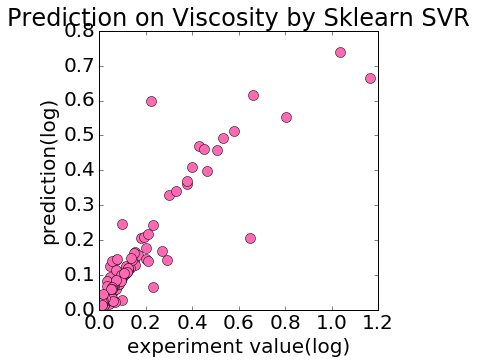

In [21]:
clf = SVR(C=1.0, epsilon=0.01,max_iter=10000)
clf.fit(X_train,Y_train)

plt.figure(figsize=(5,5))
plt.plot(Y_train,clf.predict(X_train),"o",color ='hotpink')
#plt.plot(np.arange(-6,1,0.0001),np.arange(-6,1,0.0001),color = 'black')
#plt.axis([-6,1,-6,1])
plt.xlabel('experiment value(log)')
plt.ylabel('prediction(log)')
plt.title('Prediction on Viscosity by Sklearn SVR')
plt.show()

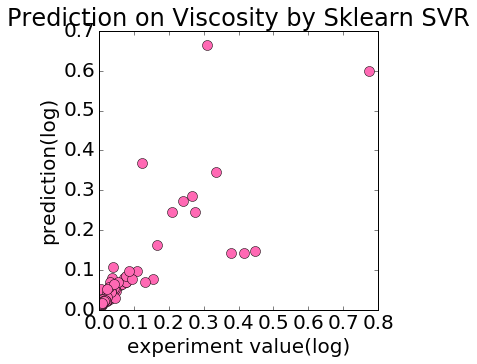

In [22]:
plt.figure(figsize=(5,5))
plt.plot(Y_test,clf.predict(X_test),"o",color ='hotpink')
plt.xlabel('experiment value(log)')
plt.ylabel('prediction(log)')
plt.title('Prediction on Viscosity by Sklearn SVR')
plt.show()

<a id='lasso load'></a>

# LASSO MODEL

[back to top](#top)

a description of lasso can be found [here](http://www.moleculardescriptors.eu/tutorials/T6_moleculardescriptors_variable_selection.pdf)

In [12]:
Deslist=data.columns.values[:-3] #save descriptor list for Coco's code
data=np.array(data)
#data=X_std
n = data.shape[0]
d = data.shape[1]
d -= 3

print(n,d)

#data = np.random.permutation(data) #if you delete, will not be random ie separate by group
X_train = np.zeros((n_train,d)) #prepare train/test arrays
X_test  = np.zeros((n_test,d))
Y_train = np.zeros((n_train))
Y_test = np.zeros((n_test))

X_train[:] = data[:n_train,:-3] #fill arrays according to train/test split
Y_train[:] = np.log(data[:n_train,-1].astype(float))

X_test[:] = data[n_train:,:-3]
Y_test[:] = np.log(data[n_train:,-1].astype(float))

print(X_train.shape)
print(X_test.shape)
print(Y_train.shape)

394 750
(326, 750)
(68, 750)
(326,)


##### <a id='coco lasso load'></a>

## Coco LASSO code

In [95]:
w = np.zeros(d) #array length of descriptors
w0 = w0last = 0
converged = False
yh = np.zeros(n_train) #prediction from model
rgl= 1 #regulation, bias against additional parameters
ITR = 100000 #iterations
itr = 0
while not converged: 
    yh = np.add(X_train.dot(w), w0*np.ones(n_train))
    w0last = w0
    wlast = np.copy(w)
    w0 = np.sum(np.subtract(Y_train, yh))/n_train
    yh = np.add(yh,(w0-w0last)*np.ones(n_train))
    for k in range (0,d):
        Xk = X_train[:,k]
        ak = Xk.T.dot(Xk)
        ck = Xk.T.dot(Y_train-yh+w[k]*Xk)
        if ck < (-1 * rgl):
            w[k] = (ck + rgl)/ak
        elif ck > rgl:
            w[k] = (ck - rgl)/ak
        else:
            w[k] = 0
        yh = np.add(yh,(w[k]-wlast[k])*X_train[:,k])    
    SUB = np.subtract(w, wlast)
    check = np.dot(SUB.T,SUB)
    if (check< 0.00000000001):
        converged = True;
        print("success")
        break     
    itr += 1
    if itr == ITR:
        print("failed")
        break

success


In [96]:
y_train = np.add(X_train.dot(w), w0*np.ones(n_train))
print(w0)
print(LINA.norm(Y_train-y_train))
D = int((d-2)/2)
wes = []  #make a df for my slides
for i in range(d):
    if w[i]>0 :
        if (i<D):
            print("CATION",Deslist[i],i)
            wes.append("CATION " + Deslist[i])
        if (i>=D and i<2*D):
            print("ANION",Deslist[i],i)
            wes.append("ANION " + Deslist[i])
        if (i == d-1):
            print("T")
        if (i == d):
            print("P")

2.70987165579e-05
1.21951623346
CATION Tschcation 247
ANION IDETanion 456
ANION ISIZanion 457
ANION Weightanion 591


In [97]:
forslides = pd.DataFrame(wes)
forslides.rename(index=int, columns={0:"Top Features"})

,Top Features
0,CATION Tschcation
1,ANION IDETanion
2,ANION ISIZanion
3,ANION Weightanion


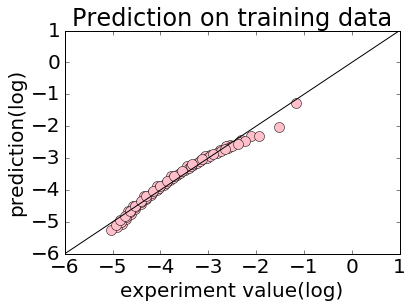

In [98]:
y_train = np.add(X_train.dot(w), w0*np.ones(n_train))
plt.plot(Y_train,y_train,"o",color ='pink')
plt.plot(np.arange(-6,1,0.0001),np.arange(-6,1,0.0001),color = 'black')
plt.axis([-6,1,-6,1])
plt.xlabel('experiment value(log)')
plt.ylabel('prediction(log)')
plt.title('Prediction on training data')
plt.show()

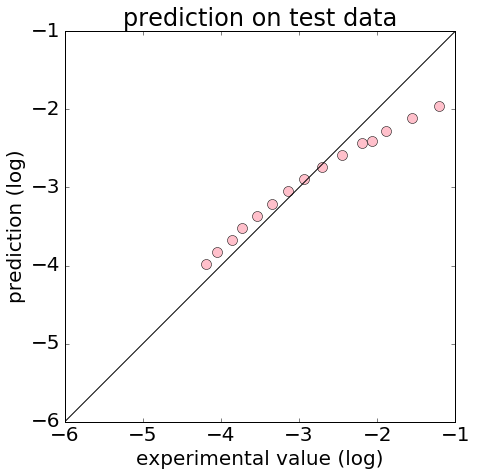

In [99]:
plt.rcParams.update(params)
y_test = np.add(X_test.dot(w), w0*np.ones(n_test))
fig=plt.figure(figsize=(7,7), dpi=300)
plt.plot(Y_test,y_test,"o",color = "pink")
plt.plot(np.arange(-6,1,0.0001),np.arange(-6,1,0.0001),color = 'black')
plt.axis([-6,1,-6,1])
plt.xlim(-6,-1)
plt.ylim(-6,-1)
plt.xlabel('experimental value (log)')
plt.ylabel('prediction (log)')
plt.title('prediction on test data')
fig.savefig(filename='lassoplot.pdf', bbox_inches='tight', format='pdf') 
plt.show()

<a id='lasso scikit load'></a>
load the choose code [here](#choose code) or see results below

## SciKitLearn LASSO 

[back to top](#top)

In [4]:
model = Lasso()
model.fit(X_train,Y_train)
model.predict(X_test)

array([-4.29467142, -4.46469153, -4.63471164, -4.80473175, -4.97475186,
       -5.14477197, -5.31479208, -5.48481218, -2.59447034, -2.76449045,
       -2.43816935, -2.60818946, -2.77820957, -2.94822968, -3.11824979,
       -3.2882699 , -3.45829   , -3.62831011, -3.79833022, -3.96835033,
       -4.13837044, -4.30839055, -4.47841065, -4.64843076, -4.81845087,
       -4.42383124, -2.04354972, -2.21356983, -2.38358994, -2.55361005,
       -2.72363015, -2.89365026, -3.06367037, -3.23369048, -3.40371059,
       -3.5737307 , -3.74375081, -3.91377091, -4.04233806, -2.17211686,
       -2.34213697, -2.51215708, -2.68217719, -2.8521973 , -2.89111035,
       -3.06113046, -3.23115057, -3.40117068, -3.57119078, -3.74121089,
       -1.8709897 , -2.04100981, -2.21102992, -2.38105003, -2.55107013,
       -2.72109024, -2.89111035, -3.06113046, -3.23115057, -3.40117068,
       -3.57119078, -2.71351566, -1.84663205, -2.01665216, -2.18667227,
       -2.35669237, -2.52671248, -2.69673259, -2.8667527 , -3.03

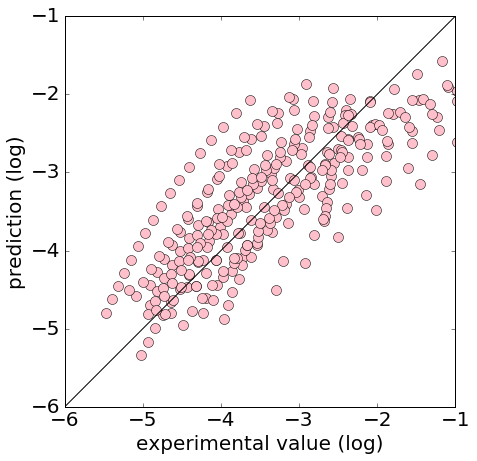

In [6]:
plt.rcParams.update(params)
fig=plt.figure(figsize=(7,7), dpi=300)
plt.plot(Y_train,model.predict(X_train),"o",color = "pink")
plt.plot(np.arange(-6,1,0.0001),np.arange(-6,1,0.0001),color = 'black')
plt.axis([-6,1,-6,1])
plt.xlim(-6,-1)
plt.ylim(-6,-1)
plt.xlabel('experimental value (log)')
plt.ylabel('prediction (log)')
#plt.title('prediction on test data')
fig.savefig(filename='lassoplot.png', bbox_inches='tight', format='png') 
plt.show()

In [11]:
plt.rcParams.update(params)
fig=plt.figure(figsize=(7,7), dpi=300)
plt.plot(Y_test,model.predict(X_test),"o",color = "pink")
plt.plot(np.arange(-6,1,0.0001),np.arange(-6,1,0.0001),color = 'black')
plt.axis([-6,1,-6,1])
plt.xlim(-6,-1)
plt.ylim(-6,-1)
plt.xlabel('experimental value (log)')
plt.ylabel('prediction (log)')
#plt.title('prediction on test data')
fig.savefig(filename='lassoplot.png', bbox_inches='tight', format='png') 
plt.show()

NameError: name 'Y_test' is not defined

<a id='mix'></a>
# Find cation, anion pairs

[back to top](#top)

In [105]:
cation = pd.Series(salts['NAME_CAT']).unique()
anion = pd.Series(salts['NAME_ANI']).unique()
print(pd.Series(salts['T']).value_counts())
print(cation)
print(anion)

323.15    26
298.15    26
313.15    26
303.15    26
333.15    24
343.15    24
318.15    23
308.15    23
293.15    22
353.15    21
328.15    20
338.15    19
348.15    18
363.15    18
283.15    17
288.15    16
358.15    15
278.15    14
373.15     5
293.00     4
368.15     4
283.00     3
333.00     3
323.00     3
313.00     3
303.00     3
343.00     3
353.00     2
273.15     2
298.00     2
          ..
323.11     1
300.00     1
328.14     1
305.00     1
338.00     1
295.16     1
365.00     1
363.00     1
360.00     1
358.00     1
355.00     1
318.16     1
350.00     1
348.00     1
345.00     1
340.00     1
335.00     1
335.05     1
333.16     1
330.00     1
328.00     1
313.17     1
325.00     1
320.00     1
318.00     1
308.13     1
315.00     1
310.00     1
308.00     1
298.16     1
Name: T, dtype: int64
['1-ethyl-3-methylimidazolium' '1-butyl-3-methylimidazolium\xc2\xa0'
 '1,3-dimethylimidazolium\xc2\xa0' '1-butyl-2,3-dimethyl-1H-imidazolium '
 '1,2-dimethyl-3-propylimidazolium\xc2\xa0

In [107]:
cation = pd.Series(salts['SMILE_cation']).unique()
anion = pd.Series(salts['SMILE_anion']).unique()
old = pd.DataFrame()
new = pd.DataFrame()
for i in range(cation.shape[0]):
    for j in range(anion.shape[0]):
        catdes=[] #descriptors for cations
        andes=[] #descriptors for anions
        cat=PyChem2d() #create PyChem molecular instances
        an=PyChem2d()
        print(cation[i],anion[j]) #check that we're computing
        cat.ReadMolFromSmile(np.str(cation[i])) #cation
        an.ReadMolFromSmile(np.str(anion[j])) #anion
        catdes.append(cat.GetAllDescriptor()) #add all the descriptors    
        andes.append(an.GetAllDescriptor()) 
        dfan = pd.DataFrame(andes) #turn the array into a dataframe
        dfcat = pd.DataFrame(catdes)
        dfan.rename(columns=lambda x: x + 'anion', inplace=True) #rename headers (cation or anion)
        dfcat.rename(columns=lambda x: x + 'cation', inplace=True)
        df = pd.concat([dfcat, dfan], axis=1) #concatonate cationic and anionic descriptor df's
        new = pd.concat([df, old], axis=0)
        old = new

CCN1C=C[N+](=C1)C C(#N)[N-]C#N
CCN1C=C[N+](=C1)C C(C(F)(F)S(=O)(=O)NS(=O)(=O)C(C(F)(F)F)(F)F)(F)(F)F
CCN1C=C[N+](=C1)C CC(=O)[O-]
CCN1C=C[N+](=C1)C C(F)(F)(F)S(=O)(=O)[N-]S(=O)(=O)C(F)(F)F
CCN1C=C[N+](=C1)C C(C(F)(F)S(=O)(=O)[N-]S(=O)(=O)C(C(F)(F)F)(F)F)(F)(F)F
CCN1C=C[N+](=C1)C COS(=O)(=O)[O-]
CCN1C=C[N+](=C1)C CCOS(=O)(=O)[O-]
CCN1C=C[N+](=C1)C CCOS(=O)(=O)[O-]

CCN1C=C[N+](=C1)C F[P-](F)(F)(F)(F)F
CCN1C=C[N+](=C1)C CS(=O)(=O)O
CCN1C=C[N+](=C1)C OCl(=O)(=O)=O
CCN1C=C[N+](=C1)C [B-](F)(F)(F)F
CCN1C=C[N+](=C1)C C(#N)[S-]
CCN1C=C[N+](=C1)C C(=C(C#N)C#N)=[N-]
CCN1C=C[N+](=C1)C C(=O)(C(F)(F)F)[O-]
CCN1C=C[N+](=C1)C C(F)(F)(F)S(=O)(=O)[O-]
CCCCN1C=C[N+](=C1)C C(#N)[N-]C#N
CCCCN1C=C[N+](=C1)C C(C(F)(F)S(=O)(=O)NS(=O)(=O)C(C(F)(F)F)(F)F)(F)(F)F
CCCCN1C=C[N+](=C1)C CC(=O)[O-]
CCCCN1C=C[N+](=C1)C C(F)(F)(F)S(=O)(=O)[N-]S(=O)(=O)C(F)(F)F
CCCCN1C=C[N+](=C1)C C(C(F)(F)S(=O)(=O)[N-]S(=O)(=O)C(C(F)(F)F)(F)F)(F)(F)F
CCCCN1C=C[N+](=C1)C COS(=O)(=O)[O-]
CCCCN1C=C[N+](=C1)C CCOS(=O)(=O)[O-]
CCCCN1C=C[N

/home/wesley/anaconda3/envs/py27/lib/python2.7/site-packages/numpy/core/_methods.py:59: RuntimeWarning: Mean of empty slice.
  warnings.warn("Mean of empty slice.", RuntimeWarning)


In [124]:
cation = pd.Series(salts['SMILE_cation']).unique() ###Grab the unique cation smiles
anion = pd.Series(salts['SMILE_anion']).unique() ###Grab the unique anion smiles
desc = new
desc=desc.reset_index()
desc.loc[:,'T'] = pd.Series(salts['T'], index=desc.index)
for a in range(desc.shape[0]):
     desc.iloc[a-1,-1] = 350
desc.loc[:,'P'] = pd.Series(salts['P'], index=desc.index)
for a in range(desc.shape[0]):
    desc.iloc[a-1,-1] = 101.325
desc.loc[:,'SMILE_cation'] = pd.Series(salts['SMILE_cation'], index=desc.index)
desc.loc[:,'SMILE_anion'] = pd.Series(salts['SMILE_anion'], index=desc.index)
a=1
for i in range(cation.shape[0]):
    for j in range(anion.shape[0]):
        desc.iloc[a-1,-2] = cation[i]
        desc.iloc[a-1,-1] = anion[j]
        a = a+1

In [125]:
pd.DataFrame.to_csv(desc, path_or_buf='newsalts')

<a id='direct'></a>
# Direct load of mixed salts

[back to top](#top)

In [126]:
data = pd.DataFrame.from_csv('newsalts') #load data
data = data.loc[:, (data != 0).any(axis=0)] #remove columns where all values are 0
desc = data
data.dropna(inplace=True) #remove empty columns and rows with NaN 
X_std = data.drop('SMILE_cation',1) #remove non-numeric columns and normalize values
X_std = X_std.drop('SMILE_anion',1)
X_std = StandardScaler().fit_transform(X_std)

In [127]:
data=np.array(data)
#data=X_std
n = data.shape[0]
d = data.shape[1]
d -= 2
n_test  = n #length of data set
print(n,d)
X_test  = np.zeros((n_test,d))
X_test[:] = data[:,:-2]
print(X_test.shape)

84 750
(84, 750)


<a id='svr'></a>

### SVR model

[back to top](#top)

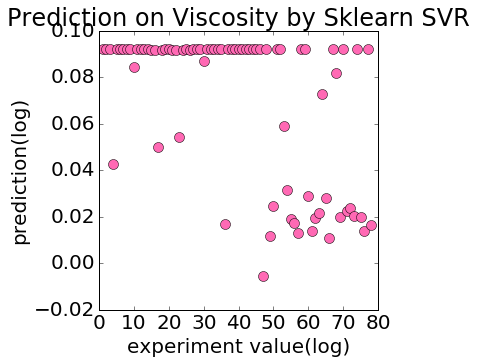

In [25]:
plt.figure(figsize=(5,5))
Y_test=np.arange(1,n+1,1)
plt.plot(Y_test,clf.predict(X_test),"o",color ='hotpink')
plt.xlabel('experiment value(log)')
plt.ylabel('prediction(log)')
plt.title('Prediction on Viscosity by Sklearn SVR')
plt.show()

In [17]:
X_test.shape

(78, 750)

<a id='coco'></a>

### Coco model

[back to top](#top)

In [122]:
plt.rcParams.update(params)
y_test = np.add(X_test.dot(w), w0*np.ones(n_test)) #w is the weights, w0 is the intercept
#y_test.sort()
Y_test=np.arange(1,n+1,1)
fig=plt.figure(figsize=(7,7), dpi=300)
plt.plot(Y_test,y_test,"o",color = "pink")
plt.xlabel('assorted salts')
plt.ylabel('prediction (log)')
plt.title('prediction on hypothetical salts')
fig.savefig(filename='lassoplot.pdf', bbox_inches='tight', format='pdf') 
plt.show()

ValueError: shapes (84,750) and (683,) not aligned: 750 (dim 1) != 683 (dim 0)

In [15]:
y_test_labeled = pd.DataFrame(y_test)
y_test_labeled.rename(columns= lambda x: "Viscosity Prediction", inplace=True)
catname = pd.Series(salts['NAME_CAT']).unique() ###Grab the unique cation smiles
anname = pd.Series(salts['NAME_ANI']).unique() ###Grab the unique anion smiles
cation = pd.Series(desc['SMILE_CAT']).unique() ###Grab the unique cation smiles
anion = pd.Series(desc['SMILE_ANI']).unique() ###Grab the unique anion smiles

y_test_labeled.loc[:,'SMILE_CAT'] = pd.Series(salts['SMILE_CAT'], index=desc.index)
y_test_labeled.loc[:,'SMILE_ANI'] = pd.Series(salts['SMILE_ANI'], index=desc.index)
y_test_labeled.loc[:,'NAME_CAT'] = pd.Series(salts['NAME_CAT'], index=desc.index)
y_test_labeled.loc[:,'NAME_ANI'] = pd.Series(salts['NAME_ANI'], index=desc.index)

a=1
for i in range(cation.shape[0]):
    for j in range(anion.shape[0]):
        y_test_labeled.iloc[a-1,0] =  np.exp(y_test_labeled.iloc[a-1,0])
        y_test_labeled.iloc[a-1,-4] = cation[i]
        y_test_labeled.iloc[a-1,-3] = anion[j]
        y_test_labeled.iloc[a-1,-2] = catname[i]
        y_test_labeled.iloc[a-1,-1] = anname[j]
        a = a+1
y_test_labeled.sort(columns="Viscosity Prediction")

/home/wesley/anaconda3/envs/py27/lib/python2.7/site-packages/IPython/kernel/__main__.py:22: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)


,Viscosity Prediction,SMILE_CAT,SMILE_ANI,NAME_CAT,NAME_ANI
37,0.001608,CN1C=C[N+](=C1)C,C(=O)(C(F)(F)F)[O-],"1,3-dimethylimidazolium",hexafluorophosphate
34,0.001727,CN1C=C[N+](=C1)C,[B-](F)(F)(F)F,"1,3-dimethylimidazolium",dicyanamide
50,0.002095,CCCC[NH+]1C=CN(C1C)C,C(=O)(C(F)(F)F)[O-],"1-butyl-2,3-dimethyl-1H-imidazolium",hexafluorophosphate
30,0.002250,CN1C=C[N+](=C1)C,COS(=O)(=O)[O-],"1,3-dimethylimidazolium",bis(perfluoroethylsulfonyl)imide
47,0.002250,CCCC[NH+]1C=CN(C1C)C,[B-](F)(F)(F)F,"1-butyl-2,3-dimethyl-1H-imidazolium",dicyanamide
76,0.002420,CCCCN1C=C[N+](=C1C)C,C(=O)(C(F)(F)F)[O-],"1,3-dimethylimidazolium",hexafluorophosphate
73,0.002598,CCCCN1C=C[N+](=C1C)C,[B-](F)(F)(F)F,"1,3-dimethylimidazolium",dicyanamide
43,0.002931,CCCC[NH+]1C=CN(C1C)C,COS(=O)(=O)[O-],"1-butyl-2,3-dimethyl-1H-imidazolium",bis(perfluoroethylsulfonyl)imide
69,0.003385,CCCCN1C=C[N+](=C1C)C,COS(=O)(=O)[O-],"1,3-dimethylimidazolium",bis(perfluoroethylsulfonyl)imide
63,0.004077,CCCN1C=C[N+](=C1C)C,C(=O)(C(F)(F)F)[O-],"1,2-dimethyl-3-propylimidazolium",hexafluorophosphate


In [100]:
catname = pd.Series(salts['NAME_CAT']).unique() ###Grab the unique cation name
anname = pd.Series(salts['NAME_ANI']).unique() ###Grab the unique anion name
cation = pd.Series(desc['SMILE_CAT']).unique() ###Grab the unique cation smiles
anion = pd.Series(desc['SMILE_ANI']).unique() ###Grab the unique anion smiles
y_test = np.add(X_test.dot(w), w0*np.ones(n_test)) #what are w, w0, n_test: length of datset
y_test.sort()
Y_test=np.arange(1,n+1,1)
fig=plt.figure(figsize=(7,7), dpi=300)
ax1 = fig.add_subplot(111)
a=0
for i in range(cation.shape[0]):
    for j in range(anion.shape[0]):
        if j==0:
            ax1.plot(Y_test[a],np.exp(y_test[a]),"o", linestyle='-', lw=2, c=tableau20[i],\
            markeredgewidth='1', markeredgecolor="black", label='%s' % cation[i])
        else:
            ax1.plot(Y_test[a],np.exp(y_test[a]),"o", linestyle='-', lw=2, c=tableau20[i],\
            markeredgewidth='1', markeredgecolor="black")
        a+=1
plt.xlabel('sorted viscosities')
plt.ylabel('prediction')
plt.title('prediction on hypothetical salts')
plt.legend(loc=2)
fig.savefig(filename='lassoprediction.png', bbox_inches='tight', format='png') 
plt.show()

NameError: name 'desc' is not defined

<a id='lasso'></a>
### LASSO model

[back to top](#top)

In [128]:
data=np.array(data)
#data=X_std
n = data.shape[0]
d = data.shape[1]
d -= 2
n_test  = n 
print(n,d)
X_test  = np.zeros((n_test,d))
X_test[:] = data[:,:-2]
print(X_test.shape)

84 750
(84, 750)


In [129]:
model.predict(X_test)

array([-4.15861163, -4.10161366, -3.93870907, -4.36116675, -4.24175528,
       -3.82208865, -3.83140167, -3.83140167, -3.82720351, -4.97981795,
       -4.31091673, -3.74627699, -4.96775622, -3.9308525 , -4.2434456 ,
       -4.18644764, -4.02354305, -4.44600072, -4.32658926, -3.90692263,
       -3.91623565, -3.91623565, -3.91203749, -5.06465193, -4.3957507 ,
       -3.83111096, -5.05259019, -4.01568647, -4.15861163, -4.10161366,
       -3.93870907, -4.36116675, -4.24175528, -3.82208865, -3.83140167,
       -3.83140167, -3.82720351, -4.97981795, -4.31091673, -3.74627699,
       -4.96775622, -3.9308525 , -4.38901299, -4.33201503, -4.16911044,
       -4.59156812, -4.47215665, -4.05249002, -4.06180304, -4.06180304,
       -4.05760488, -5.21021932, -4.54131809, -3.97667835, -5.19815759,
       -4.16125386, -4.21645297, -4.15945501, -3.99655042, -4.4190081 ,
       -4.29959663, -3.87993   , -3.88924302, -3.88924302, -3.88504486,
       -5.0376593 , -4.36875807, -3.80411833, -5.02559756, -3.98

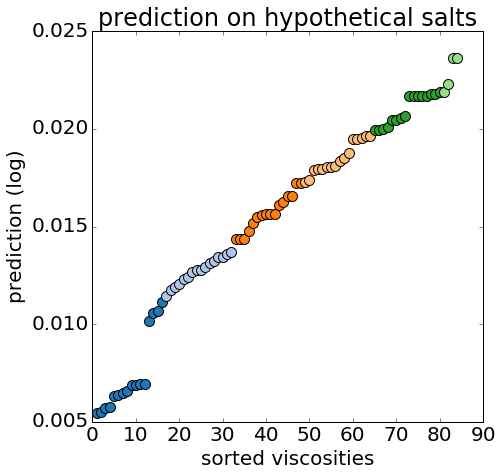

In [133]:
catname = pd.Series(salts['NAME_CAT']).unique() ###Grab the unique cation name
anname = pd.Series(salts['NAME_ANI']).unique() ###Grab the unique anion name
# cation = pd.Series(data['SMILE_cation']).unique() ###Grab the unique cation smiles
# anion = pd.Series(data['SMILE_anion']).unique() ###Grab the unique anion smiles
y_test=model.predict(X_test)
y_test.sort()
Y_test=np.arange(1,n+1,1)
fig=plt.figure(figsize=(7,7), dpi=300)
ax1 = fig.add_subplot(111)
a=0
for i in range(cation.shape[0]):
    for j in range(anion.shape[0]):
        try:
            if j==0:
                ax1.plot(Y_test[a],np.exp(y_test[a]),"o", linestyle='-', lw=2, c=tableau20[i],\
                markeredgewidth='1', markeredgecolor="black", label='%s' % cation[i])
            else:
                ax1.plot(Y_test[a],np.exp(y_test[a]),"o", linestyle='-', lw=2, c=tableau20[i],\
                markeredgewidth='1', markeredgecolor="black")
            a+=1
        except:
            pass
plt.xlabel('sorted viscosities')
plt.ylabel('prediction (log)')
plt.title('prediction on hypothetical salts')
#plt.legend(loc=2)
fig.savefig(filename='lassoprediction.jpg', bbox_inches='tight', format='jpg') 
plt.show()

<a id='descriptor load'></a>

# Other regression methods

load the choose code [here](#choose code) or see results below

## Choose Results Load

[back to top](#top)

a description of lasso can be found [here](http://www.moleculardescriptors.eu/tutorials/T6_moleculardescriptors_variable_selection.pdf)

In [9]:
choose_three_list = pd.DataFrame.from_csv('choose_three_trial1.txt')
clean = choose_three_list.loc[(choose_three_list != 0).any(axis=1),:]
top = clean.sort_values('score', ascending=False)[:20]
top

/home/wesley/anaconda3/envs/py27/lib/python2.7/site-packages/IPython/core/interactiveshell.py:2975: DtypeWarning: Columns (1,2) have mixed types. Specify dtype option on import or set low_memory=False.
  if self.run_code(code, result):


,feature two,feature three,score
feature one,,,
'ATSe5','MRVSA0','Smax',0.64018
'ATSe5','Smax','nring',0.64018
'ATSe5','Smax31','nring',0.64018
'ATSe5','Smax31','slogPVSA0',0.64018
'ATSe5','Arto','Smax',0.64018
'ATSe5','MRVSA0','Smax31',0.64018
'ATSe5','Arto','Smax31',0.64018
'ATSe5','Smax','slogPVSA0',0.64018
'ATSe5','Smax','Smax31',0.64018


In [62]:
top

,feature two,feature three,score
feature one,,,
'ATSe5','MRVSA0','Smax',0.64018
'ATSe5','Smax','nring',0.64018
'ATSe5','Smax31','nring',0.64018
'ATSe5','Smax31','slogPVSA0',0.64018
'ATSe5','Arto','Smax',0.64018
'ATSe5','MRVSA0','Smax31',0.64018
'ATSe5','Arto','Smax31',0.64018
'ATSe5','Smax','slogPVSA0',0.64018
'ATSe5','Smax','Smax31',0.64018


In [39]:
look = data[['ATSe5', 'MRVSA0', 'Smax', 'nring', 'Smax31', 'Arto',\
    'slogPVSA0', 'ATSm5', 'MZM2', 'Smax31', 'Chiv10', 'Xu', 'GMTI']]
look

,ATSe5,MRVSA0,Smax,nring,Smax31,Arto,slogPVSA0,ATSm5,MZM2,Smax31,Chiv10,Xu,GMTI
0,2.334,4.567,2.264,1.0,2.264,2.0,4.567,2.335,0.938,2.264,0.066,15.133,3.170
0,2.334,4.567,2.264,1.0,2.264,2.0,4.567,2.335,0.938,2.264,0.066,15.133,3.170
0,2.334,4.567,2.264,1.0,2.264,2.0,4.567,2.335,0.938,2.264,0.066,15.133,3.170
0,2.099,4.567,2.246,1.0,2.246,2.0,4.567,2.100,0.833,2.246,0.031,12.833,2.955
0,2.119,4.567,2.246,1.0,2.246,2.0,4.567,2.120,0.813,2.246,0.028,12.780,2.943
0,2.119,4.567,2.246,1.0,2.246,2.0,4.567,2.120,0.813,2.246,0.028,12.780,2.943
0,1.099,4.567,2.162,1.0,2.162,2.0,4.567,1.099,0.625,2.162,0.000,8.834,2.493
0,1.099,4.567,2.162,1.0,2.162,2.0,4.567,1.099,0.625,2.162,0.000,8.834,2.493
0,0.693,4.567,2.125,1.0,2.125,2.0,4.567,0.693,0.563,2.125,0.000,7.704,2.336
0,0.693,4.567,2.125,1.0,2.125,2.0,4.567,0.693,0.563,2.125,0.000,7.704,2.336


<a id='choose code'></a>
# Choose code with linear regression

[back to top](#top)

In [57]:
import itertools as it
from sklearn.linear_model import LinearRegression

cols = data.columns[0:-3]
choose_three = list(it.combinations(cols, 3))

def check_model(dataframe, feat_list, myfile):
    X = dataframe[feat_list] # selected descriptors as features
    y = dataframe[dataframe.columns[-2]] # target, in this case density
    
    model = LinearRegression()
    model.fit(X,y)
    
    features = str(feat_list).replace(",", "").replace("[","").replace("]","")
    
    line = features + ',' + str(np.sqrt(model.score(X,y))) + '\n'
    f = open(myfile, 'a')
    f.write(line)
    f.close

In [ ]:
for x in range(0,len(choose_three)):
    check_model(data, list(choose_three[x]), "choose_three_trial1.txt")

<a id='lasso code'></a>
## Choose 10 with LassoLarsIC

[back to top](#top)

In [5]:
cols = data.columns[0:-3]
choose_three = list(it.combinations(cols, 3))

def check_model(dataframe, feat_list, myfile):
    X = dataframe[feat_list] # selected amino acid columns as features
    y = dataframe[dataframe.columns[-1]] # experimental binding affinity target
    
    model = LassoLarsIC(criterion='bic')
    model.fit(X,y)
    
    features = str(feat_list).replace(",", "").replace("[","").replace("]","")
    
    line = features + ',' + str(np.sqrt(model.score(X,y))) + '\n'
    f = open(myfile, 'a')
    f.write(line)
    f.close

In [6]:
for x in range(0,len(choose_three)):
    check_model(data, list(choose_three[x]), "choose_three_trial1.txt")

KeyboardInterrupt: 

<a id='pca code'></a>
# Eigendecomposition of the covariance matrix after standardizing the data

## A Summary of the PCA Approach

[borrowed from raschka](http://sebastianraschka.com/Articles/2015_pca_in_3_steps.html)

1. Standardize the data. 

2. Obtain the Eigenvectors and Eigenvalues from the covariance matrix or correlation matrix, or perform Singular Vector Decomposition.

3. Sort eigenvalues in descending order and choose the kk eigenvectors that correspond to the kk largest eigenvalues where kk is the number of dimensions of the new feature subspace (k≤dk≤d).

4. Construct the projection matrix WW from the selected kk eigenvectors.

5. Transform the original dataset XX via WW to obtain a kk-dimensional feature subspace YY.

[back to top](#top)

In [5]:
mean_vec = np.mean(X_std, axis=0)
cov_mat = (X_std - mean_vec).T.dot((X_std - mean_vec)) / (X_std.shape[0]-1)
print('Covariance matrix \n%s' %cov_mat)

Covariance matrix 
[[ 1.08333333  1.07780708  0.99151069 ..., -0.08076998  0.1563338
  -0.31417878]
 [ 1.07780708  1.08333333  0.98443214 ..., -0.15560822  0.17052094
  -0.30011282]
 [ 0.99151069  0.98443214  1.08333333 ...,  0.25215206  0.24547601
  -0.41503812]
 ..., 
 [-0.08076998 -0.15560822  0.25215206 ...,  1.08333333  0.04036224
  -0.31230818]
 [ 0.1563338   0.17052094  0.24547601 ...,  0.04036224  1.08333333
   0.55588527]
 [-0.31417878 -0.30011282 -0.41503812 ..., -0.31230818  0.55588527
   1.08333333]]


In [6]:
#perform an eigendecomposition on the covariance matrix
cov_mat = np.cov(X_std.T)

eig_vals, eig_vecs = np.linalg.eig(cov_mat)

print('Eigenvectors \n%s' %eig_vecs)
print('\nEigenvalues \n%s' %eig_vals)

Eigenvectors 
[[-0.06582486+0.j  0.00392145+0.j -0.00278168+0.j ...,  0.00000000+0.j
   0.00000000+0.j  0.00000000+0.j]
 [-0.06536512+0.j  0.00727497+0.j -0.02375613+0.j ...,  0.00000000+0.j
   0.00000000+0.j  0.00000000+0.j]
 [-0.06114091+0.j -0.03855543+0.j -0.02537017+0.j ...,  0.00000000+0.j
   0.00000000+0.j  0.00000000+0.j]
 ..., 
 [ 0.00268884+0.j -0.09747805+0.j  0.09218894+0.j ...,  0.00000000+0.j
   0.00000000+0.j  0.00000000+0.j]
 [-0.01082992+0.j -0.01849243+0.j -0.03702343+0.j ...,  0.00000000+0.j
   0.00000000+0.j  0.00000000+0.j]
 [ 0.01958259+0.j  0.03324240+0.j  0.01833463+0.j ...,  0.00000000+0.j
   0.00000000+0.j  0.00000000+0.j]]

Eigenvalues 
[  2.49366936e+02 +0.00000000e+00j   9.18988318e+01 +0.00000000e+00j
   2.15355684e+01 +0.00000000e+00j   1.80318401e+01 +0.00000000e+00j
   2.38279871e+00 +0.00000000e+00j   1.33756485e+00 +0.00000000e+00j
   2.97931353e-02 +0.00000000e+00j   3.77215121e-14 +3.19854004e-14j
   3.77215121e-14 -3.19854004e-14j  -7.86574993e-15 

In [7]:
# Make a list of (eigenvalue, eigenvector) tuples
eig_pairs = [(np.abs(eig_vals[i]), eig_vecs[:,i]) for i in range(len(eig_vals))]

# Sort the (eigenvalue, eigenvector) tuples from high to low
eig_pairs.sort(key=lambda x: x[0], reverse=True)

# Visually confirm that the list is correctly sorted by decreasing eigenvalues
print('Eigenvalues in descending order:')
for i in eig_pairs:
    print(i[0])
    

Eigenvalues in descending order:
249.366936356
91.8988317609
21.5355684282
18.0318400964
2.3827987073
1.33756484981
0.0297931353298
4.94568328037e-14
4.94568328037e-14
4.49204003275e-14
4.49204003275e-14
4.2731344927e-14
2.96326682957e-14
2.96326682957e-14
2.42571572394e-14
2.42571572394e-14
2.42069177046e-14
2.42069177046e-14
2.40785568141e-14
2.40785568141e-14
2.37042577158e-14
2.23631707919e-14
2.23631707919e-14
2.20731612438e-14
2.20731612438e-14
2.15300048701e-14
2.15300048701e-14
1.39345150177e-14
1.39345150177e-14
1.37943118906e-14
1.37943118906e-14
1.19652441792e-14
1.19652441792e-14
9.29804522896e-15
7.95071997097e-15
7.95071997097e-15
7.47713124337e-15
7.22978553363e-15
7.22978553363e-15
6.7374273863e-15
6.7374273863e-15
6.64099073587e-15
6.44769760421e-15
6.44769760421e-15
6.20221739767e-15
6.20221739767e-15
5.94749286583e-15
5.94749286583e-15
5.90044521887e-15
5.90044521887e-15
5.78729915761e-15
5.78729915761e-15
5.6979708094e-15
5.6979708094e-15
5.57519955211e-15
5.5751995

# Explained Variance

/home/wesley/anaconda3/envs/py27/lib/python2.7/site-packages/matplotlib/patches.py:644: ComplexWarning: Casting complex values to real discards the imaginary part
  self._height = float(height)
/home/wesley/anaconda3/envs/py27/lib/python2.7/site-packages/matplotlib/patches.py:642: ComplexWarning: Casting complex values to real discards the imaginary part
  self._y = float(xy[1])
/home/wesley/anaconda3/envs/py27/lib/python2.7/site-packages/numpy/core/numeric.py:482: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


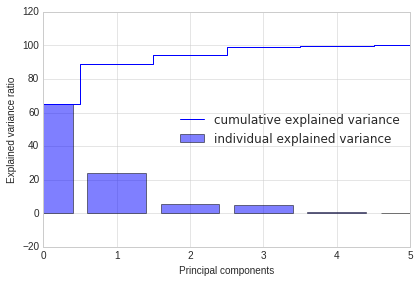

In [8]:
tot = sum(eig_vals)
var_exp = [(i / tot)*100 for i in sorted(eig_vals, reverse=True)]
cum_var_exp = np.cumsum(var_exp)
with plt.style.context('seaborn-whitegrid'):
    plt.figure(figsize=(6, 4))
    
    plt.bar(range(len(eig_vals)), var_exp, alpha=0.5, align='center',\
            label='individual explained variance')
    plt.step(range(len(eig_vals)), cum_var_exp, where='mid',
             label='cumulative explained variance')
    plt.ylabel('Explained variance ratio')
    plt.xlabel('Principal components')
    plt.legend(loc='best')
    plt.tight_layout()
    plt.xlim(0,5)

# Code Graveyard (hide yo kids)

In [9]:
#create projection matrix
matrix_w = np.hstack((eig_pairs[0][1].reshape(len(eig_pairs),1),
                      eig_pairs[1][1].reshape(len(eig_pairs),1)))

print('Matrix W:\n', matrix_w)

Matrix W:
 [[-0.06582486+0.j  0.00392145+0.j]
 [-0.06536512+0.j  0.00727497+0.j]
 [-0.06114091+0.j -0.03855543+0.j]
 [-0.06459716+0.j -0.01817619+0.j]
 [-0.06466843+0.j -0.00897559+0.j]
 [-0.06430512+0.j  0.00732021+0.j]
 [-0.06492986+0.j  0.00555251+0.j]
 [-0.06360720+0.j  0.00587202+0.j]
 [-0.06581485+0.j  0.00430262+0.j]
 [-0.06534525+0.j  0.00754304+0.j]
 [-0.06115843+0.j -0.03846345+0.j]
 [-0.06460781+0.j -0.01807680+0.j]
 [-0.06466745+0.j -0.00896407+0.j]
 [-0.06430897+0.j  0.00734116+0.j]
 [-0.06493056+0.j  0.00556512+0.j]
 [-0.06360764+0.j  0.00588557+0.j]
 [-0.06337652+0.j -0.02947463+0.j]
 [-0.06499506+0.j -0.01330904+0.j]
 [-0.05944384+0.j -0.04510235+0.j]
 [-0.06297753+0.j -0.02986047+0.j]
 [-0.06465015+0.j -0.01143812+0.j]
 [-0.06444097+0.j  0.00637376+0.j]
 [-0.06471459+0.j  0.00398569+0.j]
 [-0.06349184+0.j  0.00368551+0.j]
 [-0.06401043+0.j -0.02550915+0.j]
 [-0.06512125+0.j -0.01145742+0.j]
 [-0.05970138+0.j -0.04422315+0.j]
 [-0.06324967+0.j -0.02828961+0.j]
 [-0.0646

/home/wesley/anaconda3/envs/py27/lib/python2.7/site-packages/numpy/core/numeric.py:533: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order, subok=True)


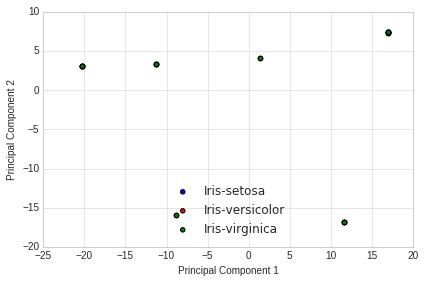

In [11]:
#Projection Onto the New Feature Space
Y = X_std.dot(matrix_w)
with plt.style.context('seaborn-whitegrid'):
    plt.figure(figsize=(6, 4))
    
    for lab, col in zip(('Iris-setosa', 'Iris-versicolor', 'Iris-virginica'),
                        ('blue', 'red', 'green')):
        plt.scatter(Y[:, 0],
                    Y[:, 1],
                    label=lab,
                    c=col)
    plt.xlabel('Principal Component 1')
    plt.ylabel('Principal Component 2')
    plt.legend(loc='lower center')
    plt.tight_layout()
    plt.show()

<a id='background'></a>
# Moreau Broto Autocorrelation

[back to top](#top)

[taken from](http://www.rguha.net/writing/notes/desc/node2.html)

Also known as Autocorrelation of a Topological Structure (ATS). The ATS descriptor describes how a property is distributed along the topological structure. It is a spatial autocorrelation on a molecular graph defined as 
\begin{displaymath}
ATS_d = \sum^{A}_{i=1} \sum^{A}_{j=1} \deltaup_{ij} \cdot (...
...=
\varmathbb{W}^T \cdot \varmathbb{B}^m \cdot \varmathbb{W}
\end{displaymath}

where $w$ is any atomic property, $A$ is the atom number (total number of atoms), $d$ is the considered topological distance,  $\deltaup_{ij}$ is the Kronecker delta,  $\varmathbb{B}^m$ is the $m$'th order binary sparse matrix (a matrix whose elements are equal to 1 only for vertices $v_i$ and $v_j$ at a distance $m$)and  $\varmathbb{W}$ is the $A$ dimensional vector of atomic properties.
For each property $w$ the set of autocorrelation terms defined for all existing distances in the graph is the ATS descriptor defined as 

\begin{displaymath}
\langle ATS_0, ATS_1, ATS_2, \cdots, ATS_D \rangle_{w}
\end{displaymath}

where $D$ is the topological diameter (maximum distance in the graph).
The average spatial autocorrelation descriptors exclude any dependence on the molecular size and are obtained by dividing each term by the corresponding number of contributions, ie, 

\begin{displaymath}
\overline{ATS}_d = \frac{1}{\Delta} \cdot \sum^{A}_{i=1} \sum^{A}_{j=1} \deltaup_{ij} \cdot (w_i
\cdot w_j)_d
\end{displaymath}

where $\Delta$ is the sum of the Kronecker deltas, ie the number of the vertex pairs at a distance $d$.
ATS descriptors for 3D geometries are based on the geometry matrix (whose entries $G_{ij}$are the Euclidean distance between atoms $i$ and $j$)

# SMRVSA MOE-type descriptors using MR contributions and surface area contributions

SMR_VSA0	Sum of vi such that Ri is in [0,0.11].